In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import numpy as np
from statsmodels.stats.anova import AnovaRM, anova_lm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# 读取数据
data = pd.read_excel('Rawdata_after_preprocessing.xlsx')

data.columns = [col.replace(' ', '_').replace(',', '') for col in data.columns]

# 选择执行功能变量
ef_measures = ['reaction_times_in_incongruent_stimuli', 'reaction_times_in_congruent_stimuli',
               'reaction_times_in_neutral_stimuli', 'stroop_interference_effect', 'accuracy_in_Go_trials',
               'reaction_times_in_Go_trials', 'accuracy_in_Nogo_trials', 'Switching_cost', 'Mixing_cost',
               'accuracy_in_1750_ms', 'accuracy_in_750_ms', 'span_in_digit_span_backward_task',
               'span_in_corsi_block_test', 'accuracy_in_corsi_block_test', 
               'Inhibition_composite', 'Executive_function_composite', 'Inhibition_and_updating_composite', 'Inhibition_and_switching_composite', 'Updating_and_switching_composite']

# 选择社会人口学变量
socio_demo_vars_cont = ['RPM', 'SES', 'Age', 'Education_years', 'BMI']
socio_demo_vars_cat = ['Gender', 'Ethnic', 'Residence', 'Only_child', 'Smoking_status', 
                       'Alcohol_consumption', 'Employed', 'Marital_status']

# 将分类变量转换为虚拟变量
data_encoded = pd.get_dummies(data[['Group'] + ef_measures + socio_demo_vars_cont + socio_demo_vars_cat], 
                              columns=socio_demo_vars_cat, drop_first=True)

# 将数据重塑为长格式
data_long = pd.melt(data_encoded, id_vars=['Group'] + socio_demo_vars_cont + [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))], 
                    var_name='EF_Measurement', value_name='Score')

# 对EF测量类型进行编码
data_long['EF_Measurement'] = data_long['EF_Measurement'].astype('category')

# 建立混合模型ANCOVA,控制社会人口学变量
formula = 'Score ~ Group * EF_Measurement + ' + ' + '.join(socio_demo_vars_cont + [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))])
model = mixedlm(formula, data=data_long, groups=data_long.index)
result = model.fit()

# 输出模型结果
print(result.summary())

# 检查交互效应的显著性
print("\nInteraction Effect (Group × EF_Measurement):")
interaction_constraints = np.eye(len(result.params))[1:15]
print(result.wald_test(interaction_constraints))

# 使用单因素ANCOVA和FDR校正检查两组在EF measures上的差异,控制社会人口学变量
print("\nOne-way ANCOVA with FDR Correction:")
p_values = []
eta_squared_values = []  # 存储eta-squared值的列表
labels = []  # 存储标签的列表

for ef_measure in ef_measures:
    formula = f'{ef_measure} ~ Group + ' + ' + '.join(socio_demo_vars_cont + [col for col in data_encoded.columns if col.startswith(tuple(socio_demo_vars_cat))])
    ancova_model = sm.formula.ols(formula, data=data_encoded).fit()
    p_values.append(ancova_model.pvalues['Group'])
    
    print(f"\n{ef_measure}:")
    print(ancova_model.summary())
    
    # 计算eta-squared (η²)
    anova_results = anova_lm(ancova_model)
    ss_group = anova_results['sum_sq']['Group']
    ss_total = anova_results['sum_sq'].sum()
    eta_squared = ss_group / ss_total
    print(f"Eta-squared (η²): {eta_squared:.2f}")
    
    eta_squared_values.append(eta_squared)  # 将eta-squared值添加到列表中
    labels.append(ef_measure)  # 将标签添加到列表中

# 应用FDR校正
rejected, corrected_p_values = multipletests(p_values, method='fdr_bh')[:2]
print("\nFDR-corrected p-values:")
for ef_measure, p, corr_p, eta_sq in zip(ef_measures, p_values, corrected_p_values, eta_squared_values):
    print(f"{ef_measure}: original p = {p:.4f}, FDR-corrected p = {corr_p:.4f}, eta-squared = {eta_sq:.3f}")

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


                                    Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  Score      
No. Observations:                    6916                     Method:                              REML       
No. Groups:                          6916                     Scale:                               5658.6440  
Min. group size:                     1                        Log-Likelihood:                      -41924.3498
Max. group size:                     1                        Converged:                           Yes        
Mean group size:                     1.0                                                                      
--------------------------------------------------------------------------------------------------------------
                                                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------

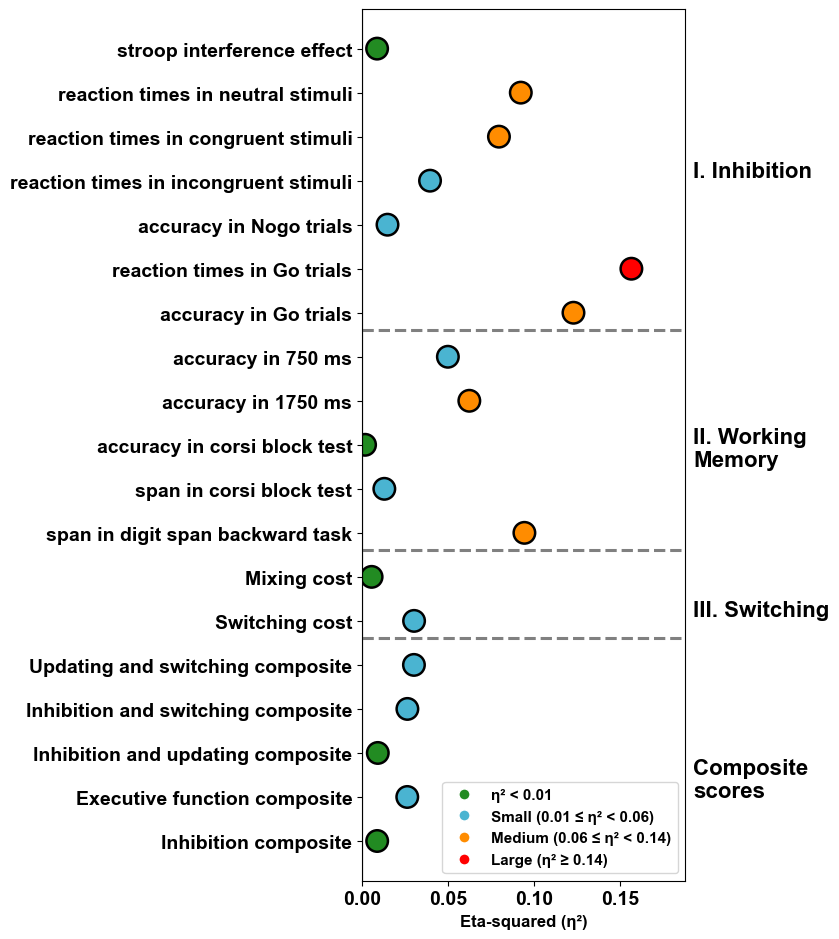

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'  # 设置字体为Arial
plt.rcParams['font.weight'] = 'bold'  # 全局字体加粗

# 定义执行功能测量指标的归属关系
ef_categories = {
    'Composite\nscores': ['Inhibition_composite', 'Executive_function_composite', 'Inhibition_and_updating_composite', 'Inhibition_and_switching_composite', 'Updating_and_switching_composite'],
    'III. Switching': ['Switching_cost', 'Mixing_cost'],
    'II. Working\nMemory': ['span_in_digit_span_backward_task', 'span_in_corsi_block_test', 'accuracy_in_corsi_block_test', 'accuracy_in_1750_ms', 'accuracy_in_750_ms'],
    'I. Inhibition': ['accuracy_in_Go_trials', 'reaction_times_in_Go_trials', 'accuracy_in_Nogo_trials', 'reaction_times_in_incongruent_stimuli', 'reaction_times_in_congruent_stimuli', 'reaction_times_in_neutral_stimuli', 'stroop_interference_effect'],
}

# 根据归属关系重新排列标签和Eta-squared值
labels_ordered = []
eta_squared_values_ordered = []
category_labels = []
category_positions = []

for category, fields in ef_categories.items():
    category_labels.append(category)
    for field in fields:
        if field in ef_measures:
            index = ef_measures.index(field)
            label = labels[index].replace("_", " ")  # 将标签中的下划线替换为空格
            labels_ordered.append(label)
            eta_squared_values_ordered.append(eta_squared_values[index])
            if field == fields[-1]:
                category_positions.append(len(labels_ordered) - 1)

# 绘制森林图
num_vars = len(labels_ordered)

fig, ax = plt.subplots(figsize=(8.5, 9.5))  # 调整图像大小

y_pos = np.arange(num_vars)

# 使用Nature风格的配色方案,根据效应量大小设置点的颜色
nature_colors = ['#228B22', '#4AB4D1', '#FF8C00', '#FF0000']
colors = []
for eta_squared in eta_squared_values_ordered:
    if eta_squared < 0.01:
        colors.append(nature_colors[0])
    elif 0.01 <= eta_squared < 0.06:
        colors.append(nature_colors[1])
    elif 0.06 <= eta_squared < 0.14:
        colors.append(nature_colors[2])
    else:
        colors.append(nature_colors[3])

ax.scatter(eta_squared_values_ordered, y_pos, color=colors, s=240, edgecolor='black', linewidth=1.8)
ax.axvline(0, color='black', linewidth=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels_ordered, fontsize=10)  # 调整字段名字的字体大小
ax.tick_params(axis='both', labelsize=14)  # 设置x轴和y轴刻度标签的字体大小
ax.set_xlabel('Eta-squared (η²)', fontsize=12, fontweight='bold')  # 设置x轴标签字体大小和粗细

plt.xlim(0, max(eta_squared_values_ordered) * 1.2)  # 增加x轴上限,以留出更多空间

# 添加图例
legend_labels = ['η² < 0.01', 'Small (0.01 ≤ η² < 0.06)', 'Medium (0.06 ≤ η² < 0.14)', 'Large (η² ≥ 0.14)']
legend_colors = [nature_colors[0], nature_colors[1], nature_colors[2], nature_colors[3]]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=legend_elements, fontsize=11, loc='lower right')  # 调整图例字体大小

# 在不同隶属类别之后绘制实线
for pos in category_positions[:-1]:
    ax.axhline(pos + 0.6, color='grey', linewidth=2.2, linestyle='--')

# 在右侧标注隶属大类的名字
for label, pos in zip(category_labels, category_positions):
    ax.text(max(eta_squared_values_ordered) * 1.23, 
            (pos + category_positions[category_labels.index(label)-1]) / 2 * 1.05 if label != category_labels[0] else pos / 2 * 0.7, 
            label, fontsize=16, va='center', fontweight='bold')  # 设置隶属大类名字字体大小和粗细
    
plt.subplots_adjust(left=0.4, right=0.8)  # 调整子图的位置,为标签留出更多空间
plt.tight_layout()

# 设置背景色为白色
fig.patch.set_facecolor('white')

# 保存图像为jpg格式,分辨率为850 dpi
plt.savefig('forest_plot.jpg', dpi=850, format='jpg', bbox_inches='tight')

plt.show()

In [8]:
print("ef_measures:", ef_measures)
print("labels:", labels)

ef_measures: ['reaction_times_in_incongruent_stimuli', 'reaction_times_in_congruent_stimuli', 'reaction_times_in_neutral_stimuli', 'stroop_interference_effect', 'accuracy_in_Go_trials', 'reaction_times_in_Go_trials', 'accuracy_in_Nogo_trials', 'Switching_cost', 'Mixing_cost', 'accuracy_in_1750_ms', 'accuracy_in_750_ms', 'span_in_digit_span_backward_task', 'span_in_corsi_block_test', 'accuracy_in_corsi_block_test', 'Inhibition_composite', 'Executive_function_composite', 'Inhibition_and_updating_composite', 'Inhibition_and_switching_composite', 'Updating_and_switching_composite']
labels: ['reaction_times_in_incongruent_stimuli', 'reaction_times_in_congruent_stimuli', 'reaction_times_in_neutral_stimuli', 'stroop_interference_effect', 'accuracy_in_Go_trials', 'reaction_times_in_Go_trials', 'accuracy_in_Nogo_trials', 'Switching_cost', 'Mixing_cost', 'accuracy_in_1750_ms', 'accuracy_in_750_ms', 'span_in_digit_span_backward_task', 'span_in_corsi_block_test', 'accuracy_in_corsi_block_test', 'I

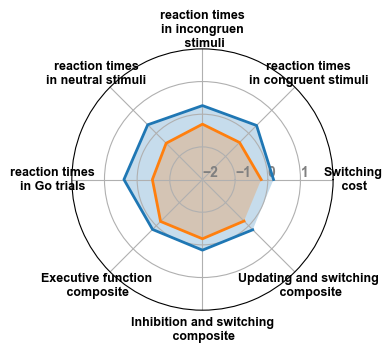

In [9]:
import matplotlib.font_manager as fm
import numpy as np
import matplotlib.pyplot as plt

# 设置全局字体为 Arial, 加粗
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 定义 EF 变量
ef_vars1 = [ 'Switching_cost','reaction_times_in_congruent_stimuli' ,'reaction_times_in_incongruent_stimuli',
            'reaction_times_in_neutral_stimuli', 
            'reaction_times_in_Go_trials','Executive_function_composite','Inhibition_and_switching_composite',
               'Updating_and_switching_composite']


groups = data['Group'].unique()
group_labels = {1: 'Schizophrenia', 2: 'Healthy Controls'}

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
theta = np.linspace(0, 2 * np.pi, len(ef_vars1), endpoint=False)

# 计算每个组在每个EF指标上的平均z-score
for group in groups:
    group_data = data[data['Group'] == group]
    group_means = group_data[ef_vars1].mean()
    group_zscores = (group_means - data[ef_vars1].mean()) / data[ef_vars1].std()
    
    # 绘制雷达图
    ax.plot(theta, group_zscores, linewidth=2, label=group_labels[group])
    ax.fill(theta, group_zscores, alpha=0.25)

# 设置角度标签
labels = [var.replace('_', ' ').replace(' in ', '\nin ') for var in ef_vars1]
labels = [label.replace('incongruent', 'incongruen\n') if 'incongruent' in label else label for label in labels]
labels = [label.replace('Switching', 'Switching\n') if 'Switching' in label else label for label in labels]
labels = [label.replace('switching', 'switching\n') if 'switching' in label else label for label in labels]
labels = [label.replace('function', 'function\n') if 'function' in label else label for label in labels]

ax.set_thetagrids(theta * 180/np.pi, labels, fontsize=9)

# 设置雷达图的范围和标签
ax.set_ylim(-2, 2)
ax.set_rlabel_position(0)
ax.set_yticks([-2, -1, 0, 1])
ax.tick_params(axis='y', colors="grey", size=6)
ax.set_ylim(-2, 2)

# 添加图例

plt.tight_layout()  # 自动调整子图参数,使之填充整个图像区域

# 保存图形为600 DPI的PNG文件
plt.savefig('radar_plot_ef_vars1.jpg', dpi=600, bbox_inches='tight')

plt.show()

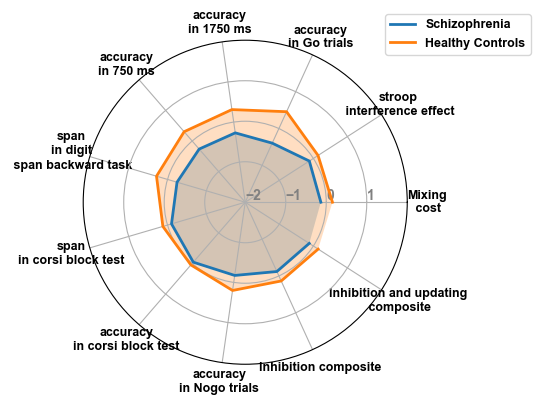

In [10]:
import matplotlib.font_manager as fm
import numpy as np
import matplotlib.pyplot as plt

# 设置全局字体为 Arial, 加粗
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

# 定义 EF 变量
ef_vars1 = ['Mixing_cost','stroop_interference_effect','accuracy_in_Go_trials', 'accuracy_in_1750_ms', 'accuracy_in_750_ms', 
            'span_in_digit_span_backward_task', 'span_in_corsi_block_test', 
            'accuracy_in_corsi_block_test', 'accuracy_in_Nogo_trials','Inhibition_composite','Inhibition_and_updating_composite']



groups = data['Group'].unique()
group_labels = {1: 'Schizophrenia', 2: 'Healthy Controls'}

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
theta = np.linspace(0, 2 * np.pi, len(ef_vars1), endpoint=False)

# 计算每个组在每个EF指标上的平均z-score
for group in groups:
    group_data = data[data['Group'] == group]
    group_means = group_data[ef_vars1].mean()
    group_zscores = (group_means - data[ef_vars1].mean()) / data[ef_vars1].std()
    
    # 绘制雷达图
    ax.plot(theta, group_zscores, linewidth=2, label=group_labels[group])
    ax.fill(theta, group_zscores, alpha=0.25)

# 设置角度标签
labels = [var.replace('_', ' ').replace(' in ', '\nin ') for var in ef_vars1]
labels = [label.replace('Mixing', 'Mixing\n') if 'Mixing' in label else label for label in labels]
labels = [label.replace('digit', 'digit\n') if 'digit' in label else label for label in labels]
labels = [label.replace('stroop', 'stroop\n') if 'stroop' in label else label for label in labels]
labels = [label.replace('updating', 'updating\n') if 'updating' in label else label for label in labels]

ax.set_thetagrids(theta * 180/np.pi, labels, fontsize=9)

# 设置雷达图的范围和标签
ax.set_ylim(-2, 2)
ax.set_rlabel_position(0)
ax.set_yticks([-2, -1, 0, 1])
ax.tick_params(axis='y', colors="grey", size=6)
ax.set_ylim(-2, 2)

# 添加图例
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1), fontsize=9)


plt.tight_layout()  # 自动调整子图参数,使之填充整个图像区域

# 保存图形为600 DPI的PNG文件
plt.savefig('radar_plot_ef_vars2.jpg', dpi=600, bbox_inches='tight')

plt.show()